#### 必要なライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import japanize_matplotlib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm


#### 共通関数のインポート
著者が学習用、予測用、学習用ログ解析用、図示用の関数を用意してくださっているのでそちらを利用する

import shutil
import os

# 削除するディレクトリのパス
dir_path = 'pythonlibs'

# ディレクトリが存在するか確認し、存在する場合は削除する
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    print(f'{dir_path} を削除しました。')
else:
    print(f'{dir_path} は存在しません。')


In [2]:
!git clone https://github.com/makaishi2/pythonlibs.git

from pythonlibs.torch_lib1 import *

fatal: destination path 'pythonlibs' already exists and is not an empty directory.


#### GPUの確認

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データの準備

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (e.g., resizing, normalization)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Randomly erase part of the image
])

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

# Define datasets
train_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/test', transform=transform)
val_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/val_reorganized', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

print(f"Train loader has {len(train_loader.dataset)} images.")
print(f"Test loader has {len(test_loader.dataset)} images.")
print(f"Validation loader has {len(val_loader.dataset)} images.")


Train loader has 100000 images.
Test loader has 10000 images.
Validation loader has 10000 images.


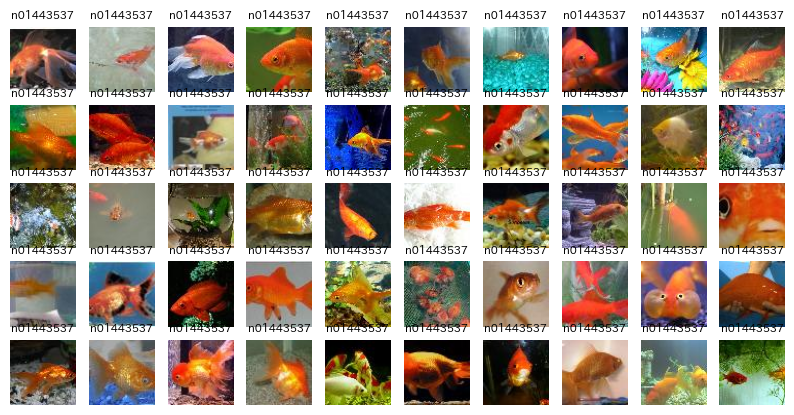

In [5]:
# Get class names (folder names) from the val_dataset
class_names = val_dataset.classes

# Get a batch of data from the val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Function to convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Function to show 50 images with their corresponding folder names
def show_images(images, labels, class_names, num_images=50):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)  # Arrange images in a 10x10 grid
        imshow(images[i])
        folder_label = class_names[labels[i].item()]  # Get folder name using label
        plt.title(folder_label, fontsize=8)  # Display folder name
        plt.axis('off')
    plt.show()

# Show 50 images and their folder names
show_images(images[:50], labels[:50], class_names)

#### Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


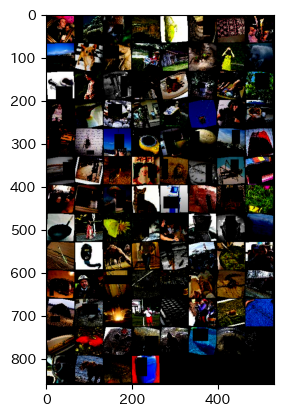

In [6]:
import torchvision  
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# Example of visualizing a batch of images
def show_batch(sample_batched):
    images_batch, labels_batch = sample_batched
    grid = torchvision.utils.make_grid(images_batch)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Load a batch and visualize
data_iter = iter(train_loader)
sample_batched = next(data_iter)
show_batch(sample_batched)



#### CNNドロップアウト

In [7]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))  # 64x64x3 → 64x64x32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))  # 64x64x32 → 64x64x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))  # 32x32x32 → 32x32x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))  # 32x32x64 → 32x32x64
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1)) # 16x16x64 → 16x16x128
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1)) # 16x16x128 → 16x16x128
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(8192, 128)  # 8x8x128 → 8192
        self.l2 = nn.Linear(128, 200)  # 128 → 200
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/100], loss: 5.21440 acc: 0.00922 val_loss: 5.08114, val_acc: 0.01810


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/100], loss: 5.04274 acc: 0.02305 val_loss: 4.86149, val_acc: 0.04290


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/100], loss: 4.88183 acc: 0.03673 val_loss: 4.66874, val_acc: 0.06050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/100], loss: 4.73976 acc: 0.05094 val_loss: 4.48461, val_acc: 0.08680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/100], loss: 4.60230 acc: 0.06621 val_loss: 4.33697, val_acc: 0.10270


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/100], loss: 4.49882 acc: 0.07746 val_loss: 4.22819, val_acc: 0.11720


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/100], loss: 4.40567 acc: 0.08686 val_loss: 4.15383, val_acc: 0.12350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/100], loss: 4.32779 acc: 0.09720 val_loss: 4.05333, val_acc: 0.13880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/100], loss: 4.26175 acc: 0.10585 val_loss: 3.98566, val_acc: 0.15100


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/100], loss: 4.19674 acc: 0.11477 val_loss: 3.93069, val_acc: 0.15790


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/100], loss: 4.14486 acc: 0.12107 val_loss: 3.85725, val_acc: 0.16130


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/100], loss: 4.09690 acc: 0.12872 val_loss: 3.76876, val_acc: 0.17430


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/100], loss: 4.05185 acc: 0.13370 val_loss: 3.72299, val_acc: 0.18430


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/100], loss: 4.01191 acc: 0.13852 val_loss: 3.71407, val_acc: 0.18940


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/100], loss: 3.97474 acc: 0.14338 val_loss: 3.63935, val_acc: 0.19470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/100], loss: 3.94064 acc: 0.14887 val_loss: 3.62523, val_acc: 0.19960


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/100], loss: 3.90118 acc: 0.15516 val_loss: 3.57664, val_acc: 0.20850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/100], loss: 3.87462 acc: 0.16106 val_loss: 3.52617, val_acc: 0.21760


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/100], loss: 3.83887 acc: 0.16342 val_loss: 3.51813, val_acc: 0.21570


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/100], loss: 3.81148 acc: 0.16860 val_loss: 3.47509, val_acc: 0.22080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/100], loss: 3.78433 acc: 0.17354 val_loss: 3.44687, val_acc: 0.22870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/100], loss: 3.75679 acc: 0.17797 val_loss: 3.40769, val_acc: 0.23470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/100], loss: 3.73169 acc: 0.17901 val_loss: 3.40549, val_acc: 0.23270


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/100], loss: 3.71471 acc: 0.18412 val_loss: 3.35110, val_acc: 0.24680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/100], loss: 3.69051 acc: 0.18597 val_loss: 3.34104, val_acc: 0.25110


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/100], loss: 3.66081 acc: 0.19076 val_loss: 3.29841, val_acc: 0.25770


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/100], loss: 3.64266 acc: 0.19437 val_loss: 3.30889, val_acc: 0.25450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/100], loss: 3.62874 acc: 0.19499 val_loss: 3.30919, val_acc: 0.25350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/100], loss: 3.60488 acc: 0.19986 val_loss: 3.25575, val_acc: 0.26700


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/100], loss: 3.59424 acc: 0.20105 val_loss: 3.24535, val_acc: 0.26680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/100], loss: 3.57490 acc: 0.20549 val_loss: 3.20693, val_acc: 0.27390


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/100], loss: 3.56107 acc: 0.20574 val_loss: 3.28316, val_acc: 0.25950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/100], loss: 3.54268 acc: 0.20915 val_loss: 3.19644, val_acc: 0.27360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/100], loss: 3.53384 acc: 0.21073 val_loss: 3.20064, val_acc: 0.27540


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/100], loss: 3.51261 acc: 0.21375 val_loss: 3.16200, val_acc: 0.28170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/100], loss: 3.49995 acc: 0.21702 val_loss: 3.17934, val_acc: 0.27420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/100], loss: 3.48855 acc: 0.21846 val_loss: 3.16522, val_acc: 0.28180


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/100], loss: 3.47129 acc: 0.22020 val_loss: 3.17125, val_acc: 0.27930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/100], loss: 3.45968 acc: 0.22159 val_loss: 3.10947, val_acc: 0.29360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/100], loss: 3.44911 acc: 0.22423 val_loss: 3.12822, val_acc: 0.28350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/100], loss: 3.44049 acc: 0.22547 val_loss: 3.08493, val_acc: 0.28930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/100], loss: 3.41819 acc: 0.23051 val_loss: 3.07954, val_acc: 0.29180


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/100], loss: 3.41041 acc: 0.23048 val_loss: 3.08572, val_acc: 0.29110


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/100], loss: 3.40031 acc: 0.23172 val_loss: 3.06363, val_acc: 0.29820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/100], loss: 3.38712 acc: 0.23432 val_loss: 3.06966, val_acc: 0.29350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/100], loss: 3.37527 acc: 0.23679 val_loss: 3.05305, val_acc: 0.29440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/100], loss: 3.36665 acc: 0.23658 val_loss: 3.04889, val_acc: 0.29390


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/100], loss: 3.35685 acc: 0.24031 val_loss: 3.07330, val_acc: 0.28880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/100], loss: 3.34881 acc: 0.24135 val_loss: 3.03478, val_acc: 0.30440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/100], loss: 3.34666 acc: 0.24049 val_loss: 3.01740, val_acc: 0.30330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [51/100], loss: 3.32862 acc: 0.24445 val_loss: 3.02403, val_acc: 0.30150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [52/100], loss: 3.31594 acc: 0.24439 val_loss: 2.98836, val_acc: 0.30980


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [53/100], loss: 3.31977 acc: 0.24621 val_loss: 2.96363, val_acc: 0.31210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [54/100], loss: 3.30553 acc: 0.24607 val_loss: 2.99631, val_acc: 0.30920


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [55/100], loss: 3.29160 acc: 0.24950 val_loss: 2.98025, val_acc: 0.30970


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [56/100], loss: 3.28473 acc: 0.24976 val_loss: 2.94015, val_acc: 0.31710


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [57/100], loss: 3.27737 acc: 0.25231 val_loss: 2.96171, val_acc: 0.31050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [58/100], loss: 3.26812 acc: 0.25454 val_loss: 2.96377, val_acc: 0.31280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [59/100], loss: 3.26337 acc: 0.25466 val_loss: 2.98347, val_acc: 0.31150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [60/100], loss: 3.24909 acc: 0.25619 val_loss: 2.94076, val_acc: 0.31540


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [61/100], loss: 3.24667 acc: 0.25753 val_loss: 2.92905, val_acc: 0.32030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [62/100], loss: 3.24069 acc: 0.25937 val_loss: 2.92702, val_acc: 0.31970


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [63/100], loss: 3.22982 acc: 0.25914 val_loss: 2.92682, val_acc: 0.31950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [64/100], loss: 3.22309 acc: 0.26177 val_loss: 2.89194, val_acc: 0.32580


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [65/100], loss: 3.21717 acc: 0.26357 val_loss: 2.88099, val_acc: 0.32990


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [66/100], loss: 3.21455 acc: 0.26417 val_loss: 2.90766, val_acc: 0.32450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [67/100], loss: 3.20277 acc: 0.26574 val_loss: 2.88593, val_acc: 0.32710


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [68/100], loss: 3.20090 acc: 0.26548 val_loss: 2.87041, val_acc: 0.33200


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [69/100], loss: 3.19247 acc: 0.26472 val_loss: 2.85282, val_acc: 0.33470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [70/100], loss: 3.18313 acc: 0.26818 val_loss: 2.87450, val_acc: 0.33140


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [71/100], loss: 3.17989 acc: 0.26913 val_loss: 2.86683, val_acc: 0.33080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [72/100], loss: 3.16875 acc: 0.27005 val_loss: 2.88516, val_acc: 0.33190


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [73/100], loss: 3.16504 acc: 0.27000 val_loss: 2.84930, val_acc: 0.33800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [74/100], loss: 3.16218 acc: 0.27123 val_loss: 2.85689, val_acc: 0.33450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [75/100], loss: 3.15976 acc: 0.27314 val_loss: 2.82549, val_acc: 0.33950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [76/100], loss: 3.14290 acc: 0.27497 val_loss: 2.83691, val_acc: 0.33660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [77/100], loss: 3.13957 acc: 0.27484 val_loss: 2.81382, val_acc: 0.34200


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [78/100], loss: 3.13806 acc: 0.27418 val_loss: 2.85257, val_acc: 0.33920


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [79/100], loss: 3.13805 acc: 0.27453 val_loss: 2.87600, val_acc: 0.33240


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [80/100], loss: 3.12869 acc: 0.27755 val_loss: 2.84535, val_acc: 0.33240


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [81/100], loss: 3.12448 acc: 0.27908 val_loss: 2.79742, val_acc: 0.34440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [82/100], loss: 3.11557 acc: 0.27862 val_loss: 2.80175, val_acc: 0.34000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [83/100], loss: 3.10970 acc: 0.28003 val_loss: 2.83888, val_acc: 0.33910


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [84/100], loss: 3.10631 acc: 0.28160 val_loss: 2.80464, val_acc: 0.34380


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [85/100], loss: 3.10614 acc: 0.28158 val_loss: 2.79136, val_acc: 0.34560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [86/100], loss: 3.10194 acc: 0.28217 val_loss: 2.79143, val_acc: 0.34670


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [87/100], loss: 3.08932 acc: 0.28413 val_loss: 2.79626, val_acc: 0.34260


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [88/100], loss: 3.09576 acc: 0.28354 val_loss: 2.79059, val_acc: 0.34610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [89/100], loss: 3.08808 acc: 0.28425 val_loss: 2.80091, val_acc: 0.34880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [90/100], loss: 3.08743 acc: 0.28530 val_loss: 2.79604, val_acc: 0.34160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [91/100], loss: 3.07772 acc: 0.28551 val_loss: 2.78557, val_acc: 0.34810


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [92/100], loss: 3.06524 acc: 0.28758 val_loss: 2.80136, val_acc: 0.34690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [93/100], loss: 3.06314 acc: 0.28792 val_loss: 2.76479, val_acc: 0.35150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [94/100], loss: 3.06290 acc: 0.28834 val_loss: 2.78136, val_acc: 0.34950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [95/100], loss: 3.05744 acc: 0.28960 val_loss: 2.76398, val_acc: 0.35420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [96/100], loss: 3.05732 acc: 0.28958 val_loss: 2.76465, val_acc: 0.35200


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [97/100], loss: 3.05450 acc: 0.29032 val_loss: 2.76136, val_acc: 0.35520


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [98/100], loss: 3.05099 acc: 0.29191 val_loss: 2.78387, val_acc: 0.34880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [99/100], loss: 3.04315 acc: 0.29030 val_loss: 2.76253, val_acc: 0.35090


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [100/100], loss: 3.04942 acc: 0.29028 val_loss: 2.73945, val_acc: 0.35610
初期状態: 損失: 5.08114 精度: 0.01810
最終状態: 損失: 2.73945 精度: 0.35610


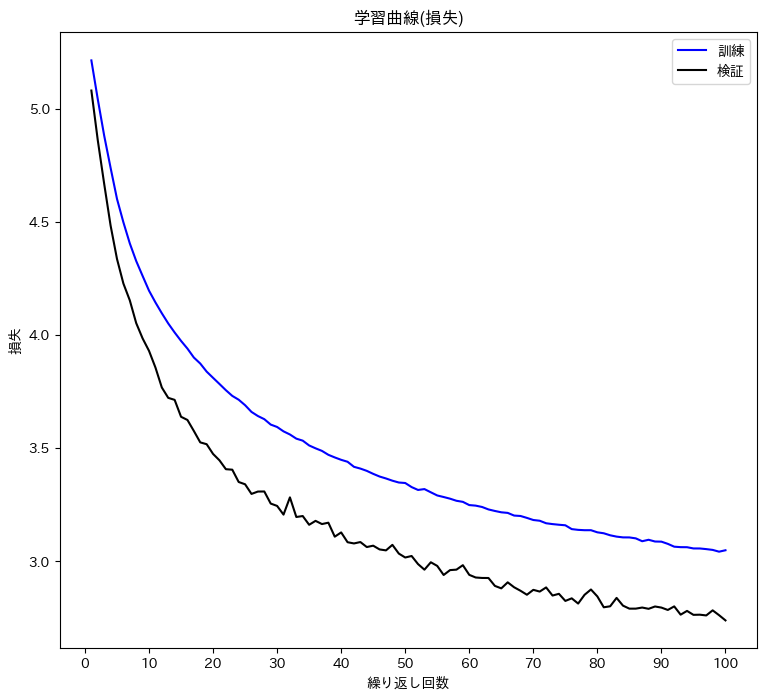

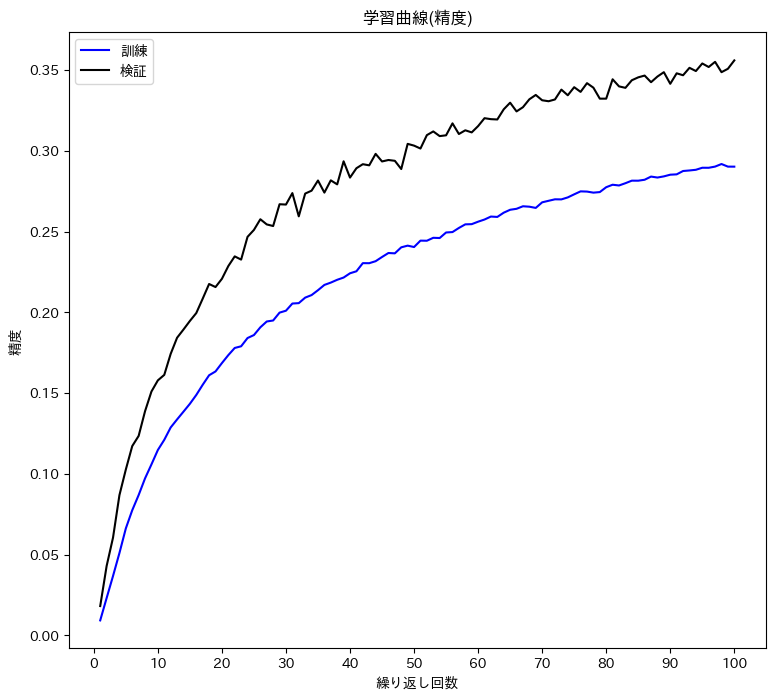

In [9]:
import numpy as np
import torch
import random

# 乱数の固定化
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# モデルインスタンス生成
net = CNN_v3(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# 訓練と検証
num_epochs = 100
history9 = np.zeros((0, 5))
history9 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history9)

# 評価履歴の表示
evaluate_history(history9)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history9)

# Resnet構造

In [10]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 4.55857 acc: 0.07115 val_loss: 4.02791, val_acc: 0.12890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 3.76991 acc: 0.16838 val_loss: 3.44824, val_acc: 0.21510


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 3.39210 acc: 0.23120 val_loss: 3.22030, val_acc: 0.25890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 3.14062 acc: 0.27649 val_loss: 3.01813, val_acc: 0.29910


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 2.92850 acc: 0.31308 val_loss: 2.85556, val_acc: 0.32890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 2.75095 acc: 0.34652 val_loss: 2.97109, val_acc: 0.31560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 2.58250 acc: 0.37911 val_loss: 2.71935, val_acc: 0.36720


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 2.42423 acc: 0.40796 val_loss: 2.65749, val_acc: 0.38100


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 2.28028 acc: 0.43717 val_loss: 2.68672, val_acc: 0.37660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 2.13540 acc: 0.46730 val_loss: 2.60111, val_acc: 0.39340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.98829 acc: 0.49622 val_loss: 2.59966, val_acc: 0.40770


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.84335 acc: 0.52705 val_loss: 2.67936, val_acc: 0.38730


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.69358 acc: 0.55957 val_loss: 2.73218, val_acc: 0.40420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.55530 acc: 0.59031 val_loss: 2.80515, val_acc: 0.39450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.40782 acc: 0.62320 val_loss: 2.85260, val_acc: 0.41040


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.26445 acc: 0.65800 val_loss: 2.92936, val_acc: 0.39970


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.14933 acc: 0.68602 val_loss: 3.01320, val_acc: 0.39390


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.03503 acc: 0.71432 val_loss: 3.23295, val_acc: 0.38290


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.93450 acc: 0.73763 val_loss: 3.16629, val_acc: 0.39820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.85584 acc: 0.75871 val_loss: 3.33932, val_acc: 0.38940


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.77467 acc: 0.78119 val_loss: 3.42542, val_acc: 0.38550


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.72267 acc: 0.79572 val_loss: 3.46505, val_acc: 0.39050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.66491 acc: 0.81040 val_loss: 3.62487, val_acc: 0.37880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.62084 acc: 0.82214 val_loss: 3.66067, val_acc: 0.39230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.58137 acc: 0.83289 val_loss: 3.69994, val_acc: 0.39030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.55526 acc: 0.84067 val_loss: 3.71780, val_acc: 0.39020


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.51976 acc: 0.85047 val_loss: 3.85232, val_acc: 0.38870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49056 acc: 0.85856 val_loss: 3.93369, val_acc: 0.38080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47110 acc: 0.86487 val_loss: 3.84437, val_acc: 0.39160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46472 acc: 0.86606 val_loss: 3.95233, val_acc: 0.38640


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.43897 acc: 0.87376 val_loss: 3.95054, val_acc: 0.38590


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.41830 acc: 0.87939 val_loss: 3.98050, val_acc: 0.39300


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.40581 acc: 0.88279 val_loss: 4.09534, val_acc: 0.37880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.39683 acc: 0.88529 val_loss: 4.10694, val_acc: 0.38850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.37730 acc: 0.89148 val_loss: 4.15229, val_acc: 0.38330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.35619 acc: 0.89797 val_loss: 4.15217, val_acc: 0.39280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.35663 acc: 0.89653 val_loss: 4.23280, val_acc: 0.37820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.34829 acc: 0.89897 val_loss: 4.19792, val_acc: 0.38020


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.34160 acc: 0.89962 val_loss: 4.27364, val_acc: 0.37790


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.32539 acc: 0.90515 val_loss: 4.26053, val_acc: 0.38270


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.32379 acc: 0.90644 val_loss: 4.29285, val_acc: 0.38180


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.31485 acc: 0.90896 val_loss: 4.41734, val_acc: 0.37530


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.30625 acc: 0.91077 val_loss: 4.32994, val_acc: 0.37990


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.29681 acc: 0.91431 val_loss: 4.34742, val_acc: 0.38600


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.29333 acc: 0.91488 val_loss: 4.32107, val_acc: 0.38490


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.28446 acc: 0.91748 val_loss: 4.32374, val_acc: 0.38580


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.27851 acc: 0.91912 val_loss: 4.37631, val_acc: 0.39030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.26995 acc: 0.92110 val_loss: 4.38790, val_acc: 0.38800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.26695 acc: 0.92254 val_loss: 4.47451, val_acc: 0.38360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.26598 acc: 0.92304 val_loss: 4.48198, val_acc: 0.37860
初期状態: 損失: 4.02791 精度: 0.12890
最終状態: 損失: 4.48198 精度: 0.37860


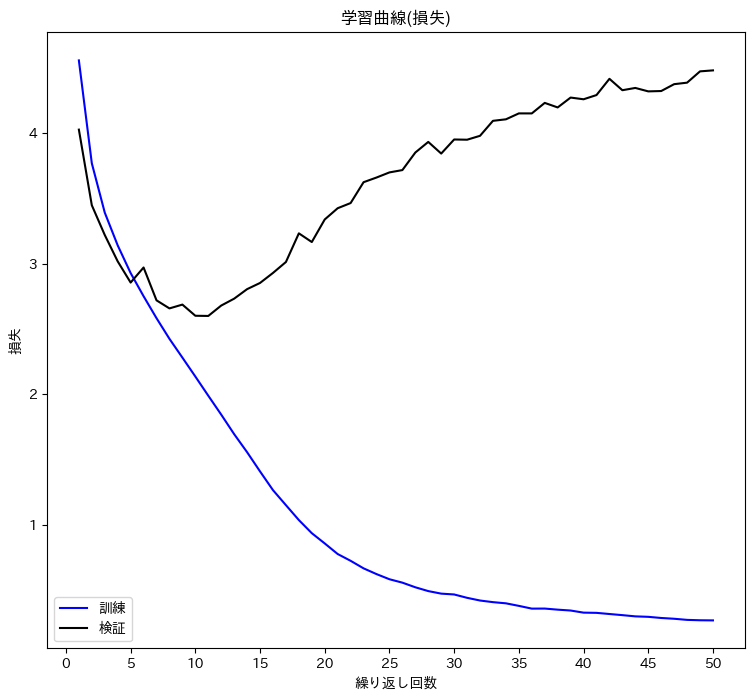

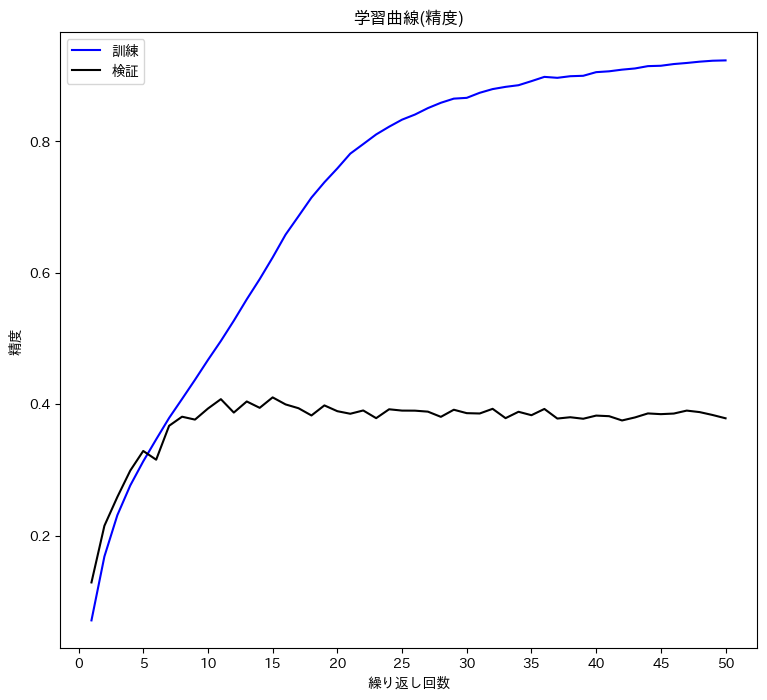

In [12]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 50
history10 = np.zeros((0, 5))
history10 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history10)

# 評価履歴の表示
evaluate_history(history10)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history10)


過学習を防ぐため、dropoutを増加する

In [12]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Apply dropout
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(dropout_rate) 
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_rate=0.5):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

   
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 4.83139 acc: 0.04187 val_loss: 4.35342, val_acc: 0.08020


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 4.10615 acc: 0.11913 val_loss: 3.81698, val_acc: 0.16000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 3.73170 acc: 0.17417 val_loss: 3.51889, val_acc: 0.20780


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 3.50797 acc: 0.21118 val_loss: 3.36592, val_acc: 0.23340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 3.32771 acc: 0.24119 val_loss: 3.15355, val_acc: 0.27650


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 3.19954 acc: 0.26361 val_loss: 3.38923, val_acc: 0.24010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 3.08656 acc: 0.28401 val_loss: 3.11433, val_acc: 0.29050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 2.97681 acc: 0.30229 val_loss: 2.95171, val_acc: 0.31480


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 2.87515 acc: 0.32213 val_loss: 2.96586, val_acc: 0.31940


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 2.79020 acc: 0.33647 val_loss: 2.96393, val_acc: 0.32480


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 2.70967 acc: 0.35152 val_loss: 2.76279, val_acc: 0.35830


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 2.63543 acc: 0.36605 val_loss: 2.86550, val_acc: 0.34240


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 2.56282 acc: 0.37973 val_loss: 2.78552, val_acc: 0.36740


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 2.50646 acc: 0.39256 val_loss: 2.78067, val_acc: 0.36400


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 2.43499 acc: 0.40542 val_loss: 2.71159, val_acc: 0.37130


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 2.36903 acc: 0.41724 val_loss: 2.59123, val_acc: 0.39780


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 2.30253 acc: 0.42933 val_loss: 2.71184, val_acc: 0.38820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 2.24974 acc: 0.44126 val_loss: 2.68537, val_acc: 0.38840


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 2.19472 acc: 0.45145 val_loss: 2.69013, val_acc: 0.39340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 2.14349 acc: 0.46063 val_loss: 2.83079, val_acc: 0.37710


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 2.08557 acc: 0.47157 val_loss: 2.69319, val_acc: 0.40620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 2.02917 acc: 0.48365 val_loss: 2.72733, val_acc: 0.40130


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.98252 acc: 0.49337 val_loss: 2.70409, val_acc: 0.39930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.93130 acc: 0.50375 val_loss: 2.76403, val_acc: 0.40520


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.88574 acc: 0.51305 val_loss: 2.75859, val_acc: 0.41280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.84675 acc: 0.51940 val_loss: 2.73543, val_acc: 0.41610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.79938 acc: 0.52931 val_loss: 2.92059, val_acc: 0.39930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.75713 acc: 0.54195 val_loss: 2.80082, val_acc: 0.41470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.71237 acc: 0.54971 val_loss: 2.86773, val_acc: 0.40830


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.66857 acc: 0.55835 val_loss: 3.01818, val_acc: 0.39100


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.63960 acc: 0.56384 val_loss: 2.97809, val_acc: 0.40020


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.59245 acc: 0.57506 val_loss: 2.94401, val_acc: 0.41530


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.55954 acc: 0.58219 val_loss: 2.96352, val_acc: 0.40770


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.52560 acc: 0.59016 val_loss: 2.98586, val_acc: 0.41300


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.48593 acc: 0.59835 val_loss: 3.08448, val_acc: 0.40490


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.45820 acc: 0.60378 val_loss: 2.99967, val_acc: 0.41230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.43040 acc: 0.60982 val_loss: 3.10340, val_acc: 0.40540


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.39537 acc: 0.61739 val_loss: 3.15805, val_acc: 0.40700


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.37314 acc: 0.62277 val_loss: 3.12972, val_acc: 0.41260


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.34633 acc: 0.62910 val_loss: 3.14032, val_acc: 0.40870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.31909 acc: 0.63806 val_loss: 3.14878, val_acc: 0.41250


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.29238 acc: 0.64425 val_loss: 3.17867, val_acc: 0.41640


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.26055 acc: 0.65040 val_loss: 3.29628, val_acc: 0.41340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.24658 acc: 0.65280 val_loss: 3.28411, val_acc: 0.41120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.22620 acc: 0.65922 val_loss: 3.27116, val_acc: 0.41540


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.20757 acc: 0.66296 val_loss: 3.35453, val_acc: 0.40890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/50], loss: 1.17342 acc: 0.67202 val_loss: 3.49196, val_acc: 0.40350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/50], loss: 1.15172 acc: 0.67602 val_loss: 3.38934, val_acc: 0.40700


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/50], loss: 1.13651 acc: 0.68085 val_loss: 3.42260, val_acc: 0.41840


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/50], loss: 1.11779 acc: 0.68555 val_loss: 3.46199, val_acc: 0.40670
初期状態: 損失: 4.35342 精度: 0.08020
最終状態: 損失: 3.46199 精度: 0.40670


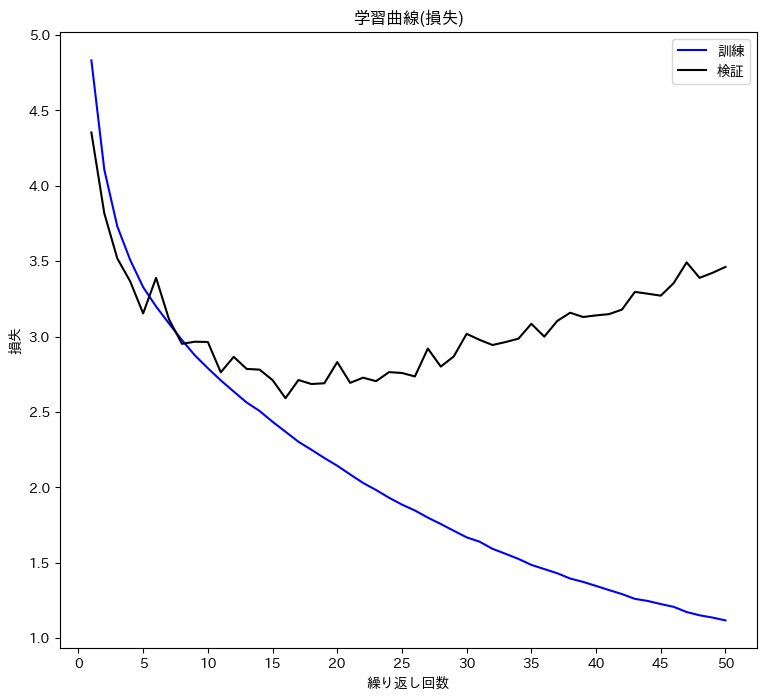

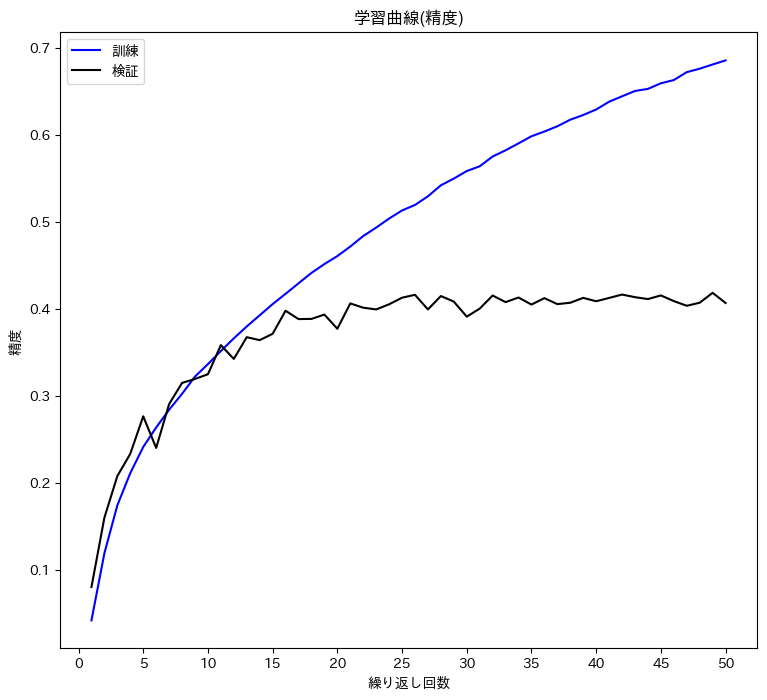

In [14]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 50
history11 = np.zeros((0, 5))
history11 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history11)

# 評価履歴の表示
evaluate_history(history11)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history11)
